In [2]:
import os
import pathlib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import shutil
import random
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D, Activation, GlobalMaxPool2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import plot_model
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import splitfolders

In [3]:
# splits dataset it into three subfolders: train, val (validation), and test.

splitfolders.ratio(r"C:\Users\ajayk\Desktop\InnoProjects\SRIT\Prediction and Analysing of Lymphoma using African vulture algorithm and owl algorithm\Original_dataset", output="output",
    seed=1337, ratio=(.75, .2, .05), group_prefix=None, move=False)

Copying files: 3256 files [00:25, 130.20 files/s]


In [4]:
data_dir = pathlib.Path('output/')
train_dir = 'output/train'
val_dir = 'output/val'
test_dir = 'output/test'

In [5]:
class_name = np.array(sorted([item.name for item in data_dir.glob("*")]))
print(class_name)

['test' 'train' 'val']


In [6]:
for dirpath, dirnames, filenames in os.walk('output'):
  print(f"{len(dirnames)} folder and {len(filenames)} images in {dirpath}")

3 folder and 0 images in output
4 folder and 0 images in output\test
0 folder and 26 images in output\test\Benign
0 folder and 50 images in output\test\Early
0 folder and 49 images in output\test\Pre
0 folder and 41 images in output\test\Pro
4 folder and 0 images in output\train
0 folder and 378 images in output\train\Benign
0 folder and 738 images in output\train\Early
0 folder and 722 images in output\train\Pre
0 folder and 603 images in output\train\Pro
4 folder and 0 images in output\val
0 folder and 100 images in output\val\Benign
0 folder and 197 images in output\val\Early
0 folder and 192 images in output\val\Pre
0 folder and 160 images in output\val\Pro


In [7]:
def view_random_image(target_dir, target_class):
    target_folder = target_dir + target_class
    random_image = random.sample(os.listdir(target_folder), 1)
    img = mpimg.imread(target_folder + "/" + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off")
    
    print(f"Image Shape : {img.shape}")
    plt.show()

Image Shape : (224, 224, 3)


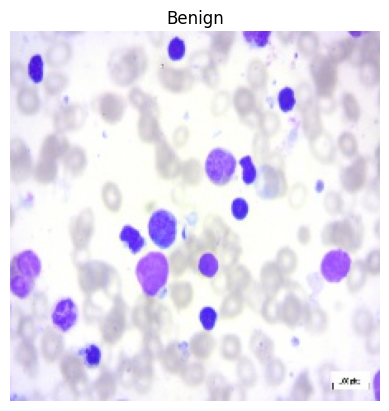

In [8]:
for i in range(1,2):
    img_n = view_random_image(target_dir='output/train/', target_class='Benign')

Image Shape : (224, 224, 3)


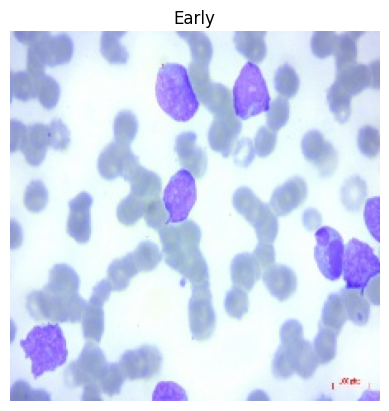

In [9]:
for i in range(1,2):
    img_n = view_random_image(target_dir='output/train/', target_class='Early')

In [10]:
# Sets the global random seed.
tf.random.set_seed(46)

# preprocess data
train_datagen = ImageDataGenerator(rescale=1/255.0,
                                   rotation_range=0.2,
                                   zoom_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   vertical_flip=True,
                                   horizontal_flip=True)
valid_datagen = ImageDataGenerator(rescale=1/255.0)
test_datagen = ImageDataGenerator(rescale=1/255.0)

In [11]:
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=64,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               shuffle=True,
                                               seed=46)

valid_data = valid_datagen.flow_from_directory(val_dir,
                                               batch_size=64,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               shuffle=False,
                                               seed=46)

test_data = test_datagen.flow_from_directory(test_dir,
                                               batch_size=64,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               shuffle=False,
                                               seed=46)

Found 2441 images belonging to 4 classes.
Found 649 images belonging to 4 classes.
Found 166 images belonging to 4 classes.


In [12]:
train_data.class_indices

{'Benign': 0, 'Early': 1, 'Pre': 2, 'Pro': 3}

In [13]:
train_y=train_data.classes
val_y=valid_data.classes
test_y=test_data.classes

In [14]:
print("train_y.shape: ", train_y.shape)
print("val_y.shape: ", val_y.shape)
print("test_y.shape: ", test_y.shape)

train_y.shape:  (2441,)
val_y.shape:  (649,)
test_y.shape:  (166,)


In [15]:
base_model = tf.keras.applications.DenseNet121(input_shape=(224, 224, 3),
                                                        include_top=False,
                                                        weights='imagenet')
base_model.trainable = False

In [16]:
global_average_layer = GlobalAveragePooling2D()
prediction_layer = Dense(4)
softmax = Activation('softmax')

inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = Dropout(0.25)(x)
x = global_average_layer(x)
outputs = prediction_layer(x)
outputs = softmax(outputs)

model = Model(inputs, outputs)

In [17]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 7, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         4,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 4)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,041,604 (26.86 MB)

 Trainable params: 4,100 (16.02 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [18]:
plot_model(model, show_shapes=True)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [19]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

# train model
history = model.fit(train_data, epochs=10, validation_data=valid_data)

Epoch 1/10


C:\Users\ajayk\anaconda3\envs\py310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


39/39 ━━━━━━━━━━━━━━━━━━━━ 416s 9s/step - accuracy: 0.4101 - loss: 1.2814 - val_accuracy: 0.8074 - val_loss: 0.7769
Epoch 2/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 357s 9s/step - accuracy: 0.8010 - loss: 0.7572 - val_accuracy: 0.9230 - val_loss: 0.5295
Epoch 3/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 433s 11s/step - accuracy: 0.8887 - loss: 0.5378 - val_accuracy: 0.9322 - val_loss: 0.3997
Epoch 4/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 456s 11s/step - accuracy: 0.9099 - loss: 0.4304 - val_accuracy: 0.9384 - val_loss: 0.3404
Epoch 5/10
39/39 ━━━━━━━━━━━━━━━━━━━━ 337s 8s/step - accuracy: 0.9253 - loss: 0.3575 - val_accuracy: 0.9430 - val_loss: 0.2824
Epoch 6/10
 4/39 ━━━━━━━━━━━━━━━━━━━━ 2:42 5s/step - accuracy: 0.9398 - loss: 0.3093

KeyboardInterrupt: 

In [20]:
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(loss))

  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title("Loss Curves")
  plt.xlabel("Epochs")
  plt.legend()

  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title("Accuracy Curves")
  plt.xlabel("Epochs")
  plt.legend()

In [21]:
plot_loss_curves(history)

NameError: name 'history' is not defined

In [22]:
val_pred = model.predict(valid_data)
val_pred = val_pred.argmax(axis=1)
print(classification_report(val_pred, val_y))

11/11 ━━━━━━━━━━━━━━━━━━━━ 68s 4s/step
              precision    recall  f1-score   support

           0       0.84      0.92      0.88        91
           1       0.97      0.91      0.94       210
           2       0.94      0.98      0.96       185
           3       0.96      0.94      0.95       163

    accuracy                           0.94       649
   macro avg       0.93      0.94      0.93       649
weighted avg       0.94      0.94      0.94       649



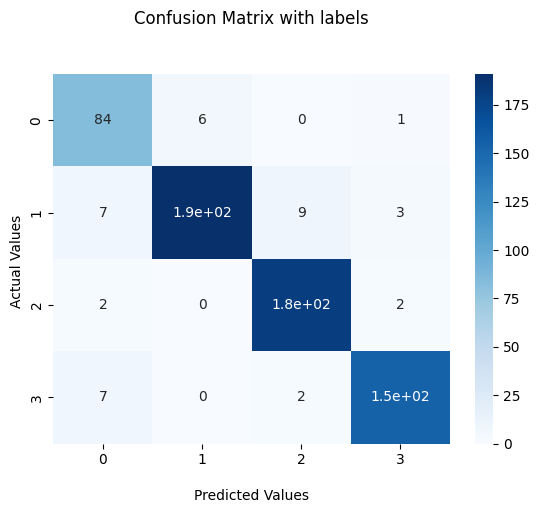

In [23]:
cfm_val = confusion_matrix(val_pred, val_y)
ax = sns.heatmap(cfm_val, annot=True, 
            cmap='Blues')

# Preparation for plotting confusion matrix
ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

# Display the visualization of the Confusion Matrix.
plt.show()

In [24]:
test_pred = model.predict(test_data)
test_pred = test_pred.argmax(axis=1)
print(classification_report(test_pred, test_y))

C:\Users\ajayk\anaconda3\envs\py310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3/3 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step
              precision    recall  f1-score   support

           0       0.92      0.92      0.92        26
           1       0.96      0.96      0.96        50
           2       0.98      0.98      0.98        49
           3       0.98      0.98      0.98        41

    accuracy                           0.96       166
   macro avg       0.96      0.96      0.96       166
weighted avg       0.96      0.96      0.96       166



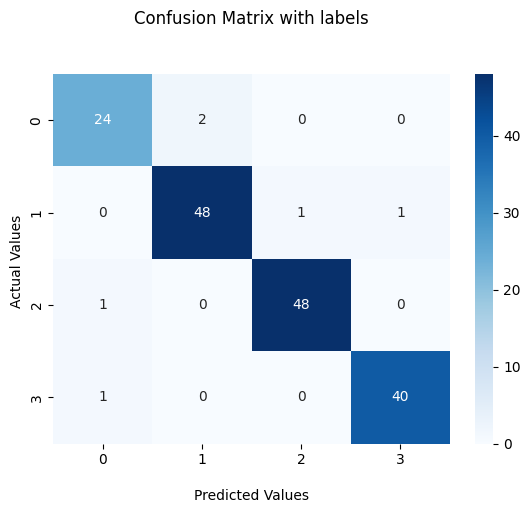

In [25]:
cfm_test = confusion_matrix(test_pred, test_y)
ax = sns.heatmap(cfm_test, annot=True, 
            cmap='Blues')

# Preparation for plotting confusion matrix
ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

# Display the visualization of the Confusion Matrix.
plt.show()

In [26]:
model.save('my_model.keras')

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted Class: Pro


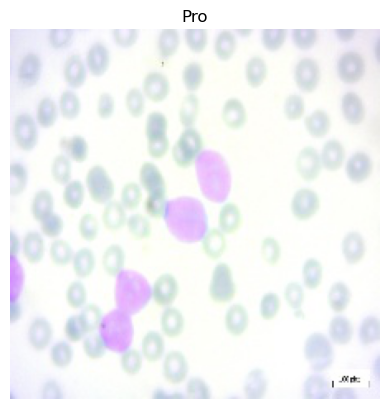

In [6]:
import matplotlib.pyplot as plt
from keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the trained model
model = load_model('my_model.keras')

# Load the image
image_path = r"C:\Users\ajayk\Desktop\InnoProjects\SRIT\Prediction and Analysing of Lymphoma using African vulture algorithm and owl algorithm\Original_dataset\Pro\WBC-Malignant-Pro-031.jpg"
img = image.load_img(image_path, target_size=(224, 224))

# Preprocess the image
img = np.array(img)
img = img / 255.0  # Normalize the image
img = img.reshape(1, 224, 224, 3)

# Predict the label
label = model.predict(img)

# Define the correct class names
class_names = ['Benign', 'Early', 'Pre', 'Pro']

# Determine the predicted class
predicted_class_index = np.argmax(label)
predicted_class = class_names[predicted_class_index]

# Print the predicted class
print("Predicted Class:", predicted_class)

# Display the image with the predicted label
plt.imshow(image.load_img(image_path))  # Use the original image path for display
plt.title(predicted_class)
plt.axis('off')
plt.show()


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data directories
train_dir = 'output/train'
val_dir = 'output/val'

# Image dimensions and batch size
input_shape = (224, 224, 3)
batch_size = 32

# Data generators
train_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
val_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

train_data = train_datagen.flow_from_directory(
    train_dir, target_size=(224, 224), batch_size=batch_size, class_mode='categorical'
)
val_data = val_datagen.flow_from_directory(
    val_dir, target_size=(224, 224), batch_size=batch_size, class_mode='categorical'
)

# Placeholder: African Vulture Optimization Algorithm
def african_vulture_optimization(search_space, objective_func, max_iter=10, population_size=20):
    """
    A placeholder implementation of the African Vulture Optimization Algorithm.
    """
    best_params = {}
    best_score = float('inf')  # For minimizing the loss
    
    # Initialize the population randomly within the search space
    population = []
    for _ in range(population_size):
        params = {key: np.random.uniform(low, high) for key, (low, high) in search_space.items()}
        population.append(params)
    
    # Optimization loop
    for _ in range(max_iter):
        for params in population:
            score = objective_func(params)
            if score < best_score:
                best_score = score
                best_params = params
    
    return best_params

# Placeholder: Owl Optimization Algorithm
def owl_optimization(search_space, objective_func, max_iter=10, population_size=20):
    """
    A placeholder implementation of the Owl Optimization Algorithm.
    """
    best_params = {}
    best_score = float('inf')  # For minimizing the loss
    
    # Initialize the population randomly within the search space
    population = []
    for _ in range(population_size):
        params = {key: np.random.uniform(low, high) for key, (low, high) in search_space.items()}
        population.append(params)
    
    # Optimization loop
    for _ in range(max_iter):
        for params in population:
            score = objective_func(params)
            if score < best_score:
                best_score = score
                best_params = params
    
    return best_params

# Define the search space
search_space = {
    'learning_rate': (0.0001, 0.01),
    'dropout_rate': (0.3, 0.7),
    'dense_units': (128, 512),
}

# Objective function to evaluate model performance
def objective_function(params):
    model = create_model(params['learning_rate'], params['dropout_rate'], int(params['dense_units']))
    model.fit(train_data, epochs=3, validation_data=val_data, verbose=1)  # Use 3 epochs for quick evaluation
    loss, _ = model.evaluate(val_data, verbose=0)
    return loss

# Function to create a CNN model
def create_model(learning_rate, dropout_rate, dense_units):
    base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze the pre-trained layers
    
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(dense_units, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    output = Dense(train_data.num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output)
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Optimize hyperparameters using AVOA
print("Optimizing hyperparameters using AVOA...")
params_avoa = african_vulture_optimization(search_space, objective_function)
model_avoa = create_model(**params_avoa)
model_avoa.fit(train_data, epochs=10, validation_data=val_data, verbose=1)  # Verbose set to 1
model_avoa.save("model_avoa.h5")
print("Model optimized with AVOA saved as 'model_avoa.h5'.")

# Optimize hyperparameters using OOA
print("Optimizing hyperparameters using OOA...")
params_ooa = owl_optimization(search_space, objective_function)
model_ooa = create_model(**params_ooa)
model_ooa.fit(train_data, epochs=10, validation_data=val_data, verbose=1)  # Verbose set to 1
model_ooa.save("model_ooa.h5")
print("Model optimized with OOA saved as 'model_ooa.h5'.")


Found 2441 images belonging to 4 classes.
Found 649 images belonging to 4 classes.
Optimizing hyperparameters using AVOA...
Epoch 1/3
77/77 ━━━━━━━━━━━━━━━━━━━━ 76s 896ms/step - accuracy: 0.7460 - loss: 0.6678 - val_accuracy: 0.9599 - val_loss: 0.1208
Epoch 2/3
77/77 ━━━━━━━━━━━━━━━━━━━━ 72s 941ms/step - accuracy: 0.9616 - loss: 0.1265 - val_accuracy: 0.9692 - val_loss: 0.0980
Epoch 3/3
77/77 ━━━━━━━━━━━━━━━━━━━━ 62s 799ms/step - accuracy: 0.9653 - loss: 0.0929 - val_accuracy: 0.9692 - val_loss: 0.0855
Epoch 1/3
77/77 ━━━━━━━━━━━━━━━━━━━━ 71s 865ms/step - accuracy: 0.6957 - loss: 0.9026 - val_accuracy: 0.9599 - val_loss: 0.1332
Epoch 2/3
77/77 ━━━━━━━━━━━━━━━━━━━━ 64s 829ms/step - accuracy: 0.9523 - loss: 0.1317 - val_accuracy: 0.9646 - val_loss: 0.1142
Epoch 3/3
77/77 ━━━━━━━━━━━━━━━━━━━━ 63s 813ms/step - accuracy: 0.9630 - loss: 0.1055 - val_accuracy: 0.9707 - val_loss: 0.0842
Epoch 1/3
77/77 ━━━━━━━━━━━━━━━━━━━━ 71s 834ms/step - accuracy: 0.7070 - loss: 1.0063 - val_accuracy: 0.9461

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step
Predicted Class (VGG16): Normal


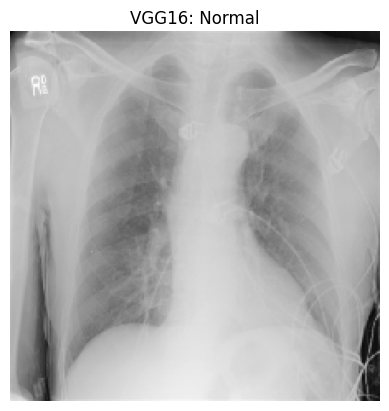

In [30]:
import matplotlib.pyplot as plt
from keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the VGG16 model
vgg16_model_path = "vgg16_model.h5"
vgg16_model = load_model(vgg16_model_path)

# Load and preprocess the image
image_path = r"C:\Users\ajayk\Desktop\InnoProjects\SRIT\Pneumonia (TB) Identification using Explainable AI\TB_Chest_Radiography_Database\Normal\Normal-14.png"
img = image.load_img(image_path, target_size=(224, 224))
img_array = np.array(img) / 255.0
img_array = img_array.reshape(1, 224, 224, 3)

# Predict with VGG16
class_names = ['Normal', 'Tuberculosis']
predictions = vgg16_model.predict(img_array)
predicted_class_index = np.argmax(predictions)
predicted_class = class_names[predicted_class_index]

# Display the result
print(f"Predicted Class (VGG16): {predicted_class}")
plt.imshow(img)
plt.title(f"VGG16: {predicted_class}")
plt.axis('off')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Class (ResNet50): Tuberculosis


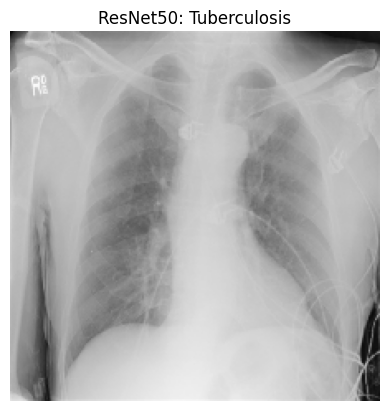

In [31]:
# Load the ResNet50 model
resnet50_model_path = "resnet50_model.h5"
resnet50_model = load_model(resnet50_model_path)

# Predict with ResNet50
predictions = resnet50_model.predict(img_array)
predicted_class_index = np.argmax(predictions)
predicted_class = class_names[predicted_class_index]

# Display the result
print(f"Predicted Class (ResNet50): {predicted_class}")
plt.imshow(img)
plt.title(f"ResNet50: {predicted_class}")
plt.axis('off')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Class (ResNet50): Tuberculosis


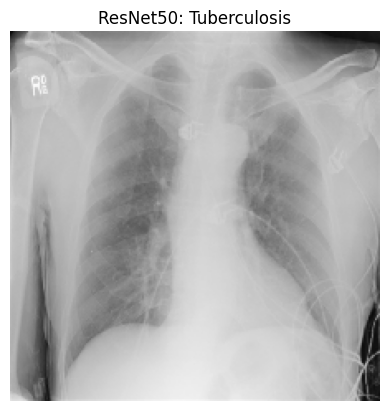

In [32]:
# Load the ResNet50 model
resnet50_model_path = "resnet50_model.h5"
resnet50_model = load_model(resnet50_model_path)

# Predict with ResNet50
predictions = resnet50_model.predict(img_array)
predicted_class_index = np.argmax(predictions)
predicted_class = class_names[predicted_class_index]

# Display the result
print(f"Predicted Class (ResNet50): {predicted_class}")
plt.imshow(img)
plt.title(f"ResNet50: {predicted_class}")
plt.axis('off')
plt.show()


In [33]:
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Load the models
vgg16_model = tf.keras.models.load_model('vgg16_model.h5')
resnet50_model = tf.keras.models.load_model('resnet50_model.h5')

# Make predictions for VGG16 model
vgg16_pred = vgg16_model.predict(test_data)
vgg16_pred = vgg16_pred.argmax(axis=1)  # Get class with highest probability

# Make predictions for ResNet50 model
resnet50_pred = resnet50_model.predict(test_data)
resnet50_pred = resnet50_pred.argmax(axis=1)  # Get class with highest probability

# True labels for the test set
test_y = test_data.classes

# Print classification report for VGG16 model
print("Classification Report for VGG16:")
print(classification_report(test_y, vgg16_pred))

# Print classification report for ResNet50 model
print("Classification Report for ResNet50:")
print(classification_report(test_y, resnet50_pred))


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Classification Report for VGG16:
              precision    recall  f1-score   support

           0       0.50      0.45      0.48        11
           1       0.67      0.71      0.69        17

    accuracy                           0.61        28
   macro avg       0.58      0.58      0.58        28
weighted avg       0.60      0.61      0.60        28

Classification Report for ResNet50:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.61      1.00      0.76        17

    accuracy                           0.61        28
   macro avg       0.30      0.50      0.38        28
weighted avg       0.37      0.61      0.46        28



C:\Users\ajayk\anaconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ajayk\anaconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ajayk\anaconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
